In [53]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [54]:
# MF
def mf(mu,ka,C,E,alpha):
    # simplified Magic Formula tyre model (providing normalised characteristics)

    B=ka/(mu*C);
    FyFz = mu*math.sin(C*math.atan((1-E)*B*alpha+E*math.atan(B*alpha)));
    
    return FyFz

Non-linear STM

In [89]:
# System dynamics 
def fdot(Xk,Uk,Vk):
    X_dot = np.zeros([4, 1])
    ## Vehicle parameters
    g = 9.81
    m = 1600      # Total mass
    l = 2.7       # Wheel base
    lf = 1.35     # CoG distance to front axle
    Jz = 3000     # Yaw moment of inertia
    
    # tire parameters
    Kf = 80000 / (m*g*(l-lf)/l)    # Normalized cornering stiffness front
    Kr = 100000 / (m*g*lf/l)   # Cornering stiffness rear
    SigF = 0.3 # front elation length
    SigR = 0.5 # rear elation length
    
    # shape parameter for tire lateral force
    mu = 1
    C = 1.3
    E = -1
    

    V = Vk        # Forward speed
    
    # Non-linear tire characteristics
    alphaF = Uk - (Xk[1] * lf + Xk[0])/V
    Ff = mf(mu,Kf,C,E,alphaF)*m*g*(l-lf)/l
#     print(Ff) 
#     if Ff > mu*(l - lf)/l*m*g: Ff = mu*(l - lf)/l*m*g
    alphaR = (Xk[1] * (l - lf) - Xk[0])/V
    Fr = mf(mu,Kr,C,E,alphaR)*m*g*lf/l
#     if abs(Fr) > mu*lf/l*m*g: Fr = mu*lf/l*m*g

    X_dot[0:1] = (1/m*(Xk[2]+ Xk[3])) - V*Xk[1]       # v_dot
    X_dot[1:2] = 1/Jz*(Xk[2]*lf - Xk[3]*(l-lf))       # phi_dot
#     X_dot[0:1] = (1/m*(Ff+ Fr)) - V*Xk[1]       # v_dot
#     X_dot[1:2] = 1/Jz*(Ff*lf - Fr*(l-lf))       # phi_dot
    X_dot[2:3] = V/SigF * (Ff - Xk[2]) # Force dynamics lateral front (PT-1)
    X_dot[3:4] = V/SigR * (Fr - Xk[3]) # Force dynamics lateral rear (PT-1)
#     print(Ff)    
    return X_dot

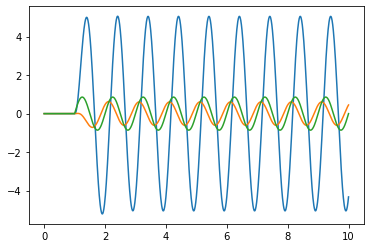

In [90]:
##simulation
V = 30 # Forward speed
time = 10 # [s]
dt = 0.01
N = int(time/dt)
X = np.zeros([4, N+1])
U = np.zeros(N+1)
X[:,0] = [0,0,0,0]

temp = 0

######################################################
# Define input
######################################################
max_U = 0.003    # [rad] SS front wheel angle
strt_U = 1     # [s] Start of steering action
rate_U = 0.4   # [rad/s]Rate of steering action
pha = 0
NU = int(strt_U/dt+1)
for i in range(N-NU):
     
## sine wave #####################################
    pha = pha + 2*np.pi*dt
    temp = 0.015*math.sin(pha) 
    U[i + NU] = temp
##################################################

## Step steer#####################################
#     temp = temp + dt*rate_U
#     U[i + NU] = temp
#     if temp > max_U:
#         U[i + NU:] = max_U
#         break
# #################################################        
        
## Impulse Steer #################################
#     pha = pha + 4*np.pi*dt
#     temp = max_U*math.sin(pha)
#     U[i + NU] = temp
#     if i >= 0.25/dt:
#         U[i + NU:] = 0
#         break
##################################################

######################################################

# Integration RK4
for i in range(N):
    Xk = X[:,i:i+1]
    Uk = U[i]
    k1 = fdot(Xk,Uk,V)
    k2 = fdot(Xk+ k1 * dt/2,Uk,V)
    k3 = fdot(Xk+ k2 * dt/2,Uk,V)
    k4 = fdot(Xk+ k3 * dt,Uk,V)
    X[:,i+1:i+2] = Xk + (k1 + 2*k2 + 2*k3 + k4)*dt/6
    
plt.plot(np.linspace(0, time, num=N+1),X[1,:]*180/np.pi)     # Yaw rate
plt.plot(np.linspace(0, time, num=N+1),X[0,:]/V*180/np.pi)  # sideslip
plt.plot(np.linspace(0, time, num=N+1),U*180/np.pi)

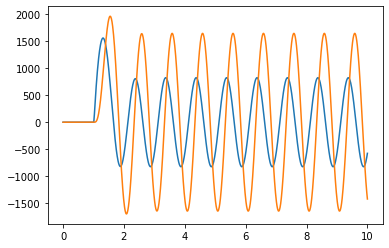

In [92]:
plt.plot(np.linspace(0, time, num=N+1),X[2,:]*1.35)   # Yaw moment from FA
plt.plot(np.linspace(0, time, num=N+1),X[3,:]*1.35)   # Anti-Yaw moment from RA

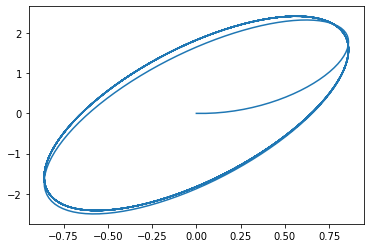

In [85]:
plt.plot(U*180/np.pi,(X[0,:]+X[1,:]*V))   # phase portrait

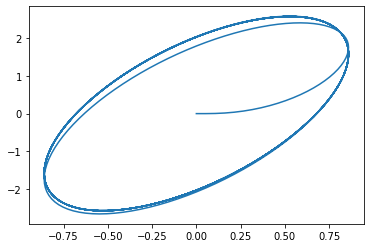

In [91]:
plt.plot(U*180/np.pi,(X[0,:]+X[1,:]*V))   # phase portrait

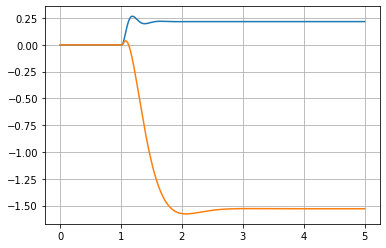

In [58]:
# comparing different speeds
for V in [10,30]:
#     vehPars = {"mass": 1600,
#            "l_front": 1.35,
#            "l_rear": 1.35,
#            "WB": 2.7,
#            "Jz": 3000,
#            "TrackWidth_f": 1.6,
#            "TrackWidth_r": 1.6,
#            "CG_Height": 0.5,
#            "RCH": 0.3,
#            "k_roll":sig_f,
#            "sigma_f": V/2}   # TLLTD
    ##simulation
    time = 5 # [s]
    dt = 0.01
    N = int(time/dt)
    X = np.zeros([4, N+1])
    U = np.zeros(N+1)
    Fy = np.zeros(4)
    Fz = np.zeros(4)
    alpha = np.zeros(4)
    X[:,0] = [0,0,0,0]
    max_U = 0.02    # [rad] SS front wheel angle
    strt_U = 1     # [s] Start of steering action
    rate_U = 1   # [rad/s]Rate of steering action
#     Fz[0] = 0.5 * vehPars["mass"] * 9.81 * vehPars["l_rear"] / vehPars["WB"]
#     Fz[1] = 0.5 * vehPars["mass"] * 9.81 * vehPars["l_rear"] / vehPars["WB"]
#     Fz[2] = 0.5 * vehPars["mass"] * 9.81 * vehPars["l_front"] / vehPars["WB"]
#     Fz[3] = 0.5 * vehPars["mass"] * 9.81 * vehPars["l_front"] / vehPars["WB"]
    NU = int(strt_U/dt+1)
    temp = 0
    pha = 0
    for i in range(N-NU):
    ## sine wave #####################################
#         pha = pha + 0.5*np.pi*dt
#         temp = 0.03*math.sin(pha) 
#         U[i + NU] = temp
    ##################################################

    ## Step steer#####################################
        temp = temp + dt*rate_U
        U[i + NU] = temp
        if temp > max_U:
            U[i + NU:] = max_U
            break
    ##################################################        

    ## Impulse Steer #################################
    #     pha = pha + 2*np.pi*dt
    #     temp = 0.03*math.sin(pha)
    #     U[i + NU] = temp
    #     if i >= 0.5/dt:
    #         U[i + NU:] = 0
    #         break
    ##################################################

    ## Integration RK4
    for i in range(N):
        Xk = X[:,i:i+1]
        Uk = U[i]
        k1 = fdot(Xk,Uk,V)
    #     print(k1)
        k2 = fdot(Xk+ k1 * dt/2,Uk,V)
        k3 = fdot(Xk+ k2 * dt/2,Uk,V)
        k4 = fdot(Xk+ k3 * dt,Uk,V)
        X[:,i+1:i+2] = Xk + (k1 + 2*k2 + 2*k3 + k4)*dt/6
    
#     plt.plot(np.linspace(0, time, num=N+1),X[1,:]*180/np.pi)
    plt.plot(np.linspace(0, time, num=N+1),X[0,:]/V*180/np.pi)
# plt.plot(np.linspace(0, time, num=N+1),U*180/np.pi*15)
plt.grid()

In [ ]:
# next Bode plots...